<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 37px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Machine Learning<br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  -<br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Illustration with Random Forests<br><br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      <font color=orange> 5 - Model Interpretation</font>
  </div>

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      BSc - Fall 2024
  </div>




### Model Interpretation

-  [Random Forest features importance](#RF_feature_importance)<br>
-  [Permutation importance](#permutation_feature_importance)<br>
-  [Feature correlations](#redundant_features)<br>


[Bottom](#bottom)

### Imports

In [133]:
# for package auto reload
%load_ext autoreload
%autoreload 2

# for better rendering of plots in jupyter notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# base modules
import os
import sys
import copy
import logging
import math

# for manipulating data
import numpy as np
import pandas as pd
import dill
import scipy

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
# plotly
# seaborn
# altair

In [135]:
# path to repo
path_to_repo = os.path.dirname(os.getcwd())
path_to_repo

'/Users/jiaokan/Workshop/Machine Learning in Practice'

In [136]:
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

# custom module
from mlpcourse.utils import *

In [137]:
path_to_repo = os.path.dirname(os.getcwd())

path_to_bulldozers = os.path.join(path_to_repo, "data", "bulldozers", "")

In [138]:
path_to_bulldozers

'/Users/jiaokan/Workshop/Machine Learning in Practice/data/bulldozers/'

#  Model Interpretation

[Back to top](#plan)

In [195]:
# define the path to dataset
path_to_dataset = os.path.join(
    path_to_repo, "data", 'bulldozers', 'bulldozers-raw')
print(path_to_dataset)

# import raw data
# df_raw = pd.read_csv(path_to_datasets, low_memory = False, parse_dates = ["saledate"])
# df_raw.SalePrice = np.log(df_raw.SalePrice)
df_raw = pd.read_feather(path_to_dataset)

# preprocess data
df, y, nas = proc_df(df_raw, 'SalePrice')

/Users/jiaokan/Workshop/Machine Learning in Practice/data/bulldozers/bulldozers-raw


In [140]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [141]:
n_total = len(df)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(df, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


In [142]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())


def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

<a id='RF_feature_importance'></a>

### $\bullet$ Random Forest feature importance

[Back to top](#plan)

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

Scikit-learn's implementation of Random Forests carry _impurity-based_ feature importance scores (the higher, the more important the feature) in the attribute `model.feature_importances_` of a fitted model. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature on the training set. 

Since they are computed on the training set these scores should be taken with caution, as the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit. As a result, features that are deemed of low importance for a bad model (high training score but low validation/cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a validation set (or better with cross-validation) prior to computing importances. These feature importance does not reflect to the intrinsic predictive value of a feature by itself, but how important this feature is for a particular random forest.


See more on the [scikit-learn documentation](https://scikit-learn.org/stable/modules/partial_dependence.html).

In [143]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


def rf_unfolded_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    for i, tree in enumerate(model.estimators_):
        feat_importance['imp_' + str(i)] = tree.feature_importances_
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


# found at
# https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees
def tree_feature_importance(model, normalize = True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx, node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node] += (
                impurity[idx]*node_samples[idx] -
                impurity[left_c[idx]]*node_samples[left_c[idx]] -
                impurity[right_c[idx]]*node_samples[right_c[idx]])

    # Number of samples at the root node
    feature_importance /= node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance /= normalizer

    return feature_importance

In [144]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 4.04 s, sys: 76 ms, total: 4.12 s
Wall time: 742 ms
RMSE on train set: 0.1486
RMSE on valid set: 0.3269
R^2 on train set: 0.9554
R^2 on valid set: 0.8092
R^2 on oob set: 0.8885


In [145]:
model.feature_importances_

array([9.96301788e-03, 2.31820915e-02, 3.54066146e-02, 0.00000000e+00,
       0.00000000e+00, 9.46533440e-02, 2.36793885e-02, 2.93622942e-02,
       2.97744597e-02, 2.23505037e-02, 5.65654671e-02, 4.97645135e-03,
       2.05558331e-02, 5.57311965e-02, 6.97890696e-02, 6.70707306e-03,
       1.48058873e-02, 8.47267804e-03, 3.97242067e-03, 1.33562332e-01,
       1.17940146e-03, 2.96108858e-03, 4.21532697e-04, 1.96752499e-03,
       5.82227188e-03, 5.09269579e-04, 5.31006219e-04, 2.71057918e-03,
       6.18772056e-04, 7.00503769e-04, 9.94555886e-03, 6.23930291e-04,
       4.93336022e-03, 1.35210729e-03, 6.52734223e-04, 7.04223350e-03,
       1.76646982e-03, 1.20493397e-01, 3.16733496e-02, 7.67596785e-02,
       9.79426395e-03, 2.14248034e-03, 2.99631115e-03, 9.16875315e-04,
       9.90267398e-04, 3.50681357e-04, 2.54969794e-04, 2.40373466e-03,
       5.73778776e-03, 1.95741209e-04, 2.41990993e-04, 9.01556011e-03,
       2.25415931e-03, 4.10002864e-03, 5.48178808e-03, 1.13149603e-03,
      

#### Feature importance of a single tree

In [146]:
# pick the first tree of the forest
tree = model.estimators_[0]

We propose 3 ways to access the feature importances of a single tree, with one given by the function `tree_feature_importance` which can serve as an explanation of how these scores are computed:

In [147]:
# method 1
# tree.tree_.compute_feature_importances(normalize = True)

# method 2
# tree_feature_importance(tree, normalize = True)

# method 3
tree.feature_importances_

array([7.68506067e-03, 1.41176009e-02, 5.58616781e-02, 0.00000000e+00,
       0.00000000e+00, 7.88805847e-02, 2.09935427e-02, 9.55777128e-03,
       3.88016394e-02, 2.24585495e-02, 4.59295315e-02, 3.19345389e-03,
       2.85906599e-02, 3.17471703e-02, 2.86819767e-02, 6.39433172e-03,
       1.85805911e-02, 8.33162464e-03, 3.65401459e-04, 3.25996974e-01,
       1.84393873e-02, 1.14009798e-04, 3.24907620e-04, 2.24401243e-04,
       3.69141040e-03, 2.56407401e-04, 0.00000000e+00, 8.27202919e-05,
       4.98694647e-05, 1.46418047e-03, 1.29204021e-01, 3.29141857e-05,
       3.26901661e-03, 4.42661908e-04, 1.25058041e-03, 8.04662553e-03,
       2.22503176e-03, 7.72240329e-03, 2.13466713e-04, 4.24962889e-03,
       9.36030000e-04, 1.37319830e-03, 3.56301187e-04, 6.37781636e-04,
       2.68687298e-04, 4.28321437e-04, 8.76216322e-05, 9.04334655e-04,
       1.35559469e-03, 5.21332116e-05, 2.63684286e-04, 6.76993681e-03,
       2.71815419e-03, 5.20064347e-03, 5.81886319e-03, 8.80586225e-04,
      

In [148]:
feat_importance = rf_feat_importance(tree, X_small)
feat_importance[:20]

,cols,imp
19,Enclosure,0.325997
30,Hydraulics,0.129204
5,YearMade,0.078881
2,ModelID,0.055862
10,fiSecondaryDesc,0.045930
8,fiModelDesc,0.038802
63,saleElapsed,0.037857
13,ProductSize,0.031747
14,fiProductClassDesc,0.028682
12,fiModelDescriptor,0.028591


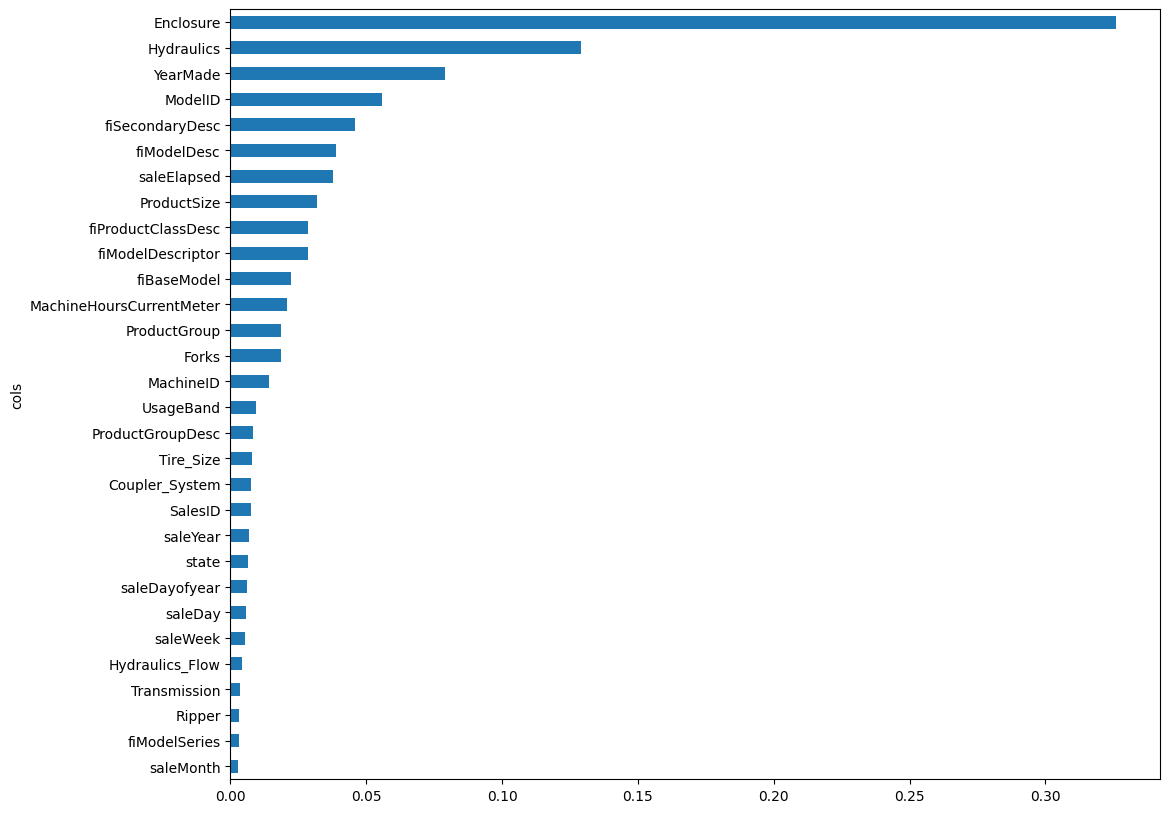

In [149]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

#### Feature importance of the whole random forest

Each tree of the random forest carries its own feature importance along the explanatory variables (variables unseen during training simply have score 0.0). The overall feature importance of the random forest is then naturally defined as the _average, feature by feature, of the importance scores computed by each tree_.

In [150]:
feat_importance = rf_feat_importance(model, X_small)
feat_importance[:20]

,cols,imp
19,Enclosure,0.133562
37,Coupler_System,0.120493
5,YearMade,0.094653
39,Hydraulics_Flow,0.076760
14,fiProductClassDesc,0.069789
10,fiSecondaryDesc,0.056565
13,ProductSize,0.055731
2,ModelID,0.035407
38,Grouser_Tracks,0.031673
8,fiModelDesc,0.029774


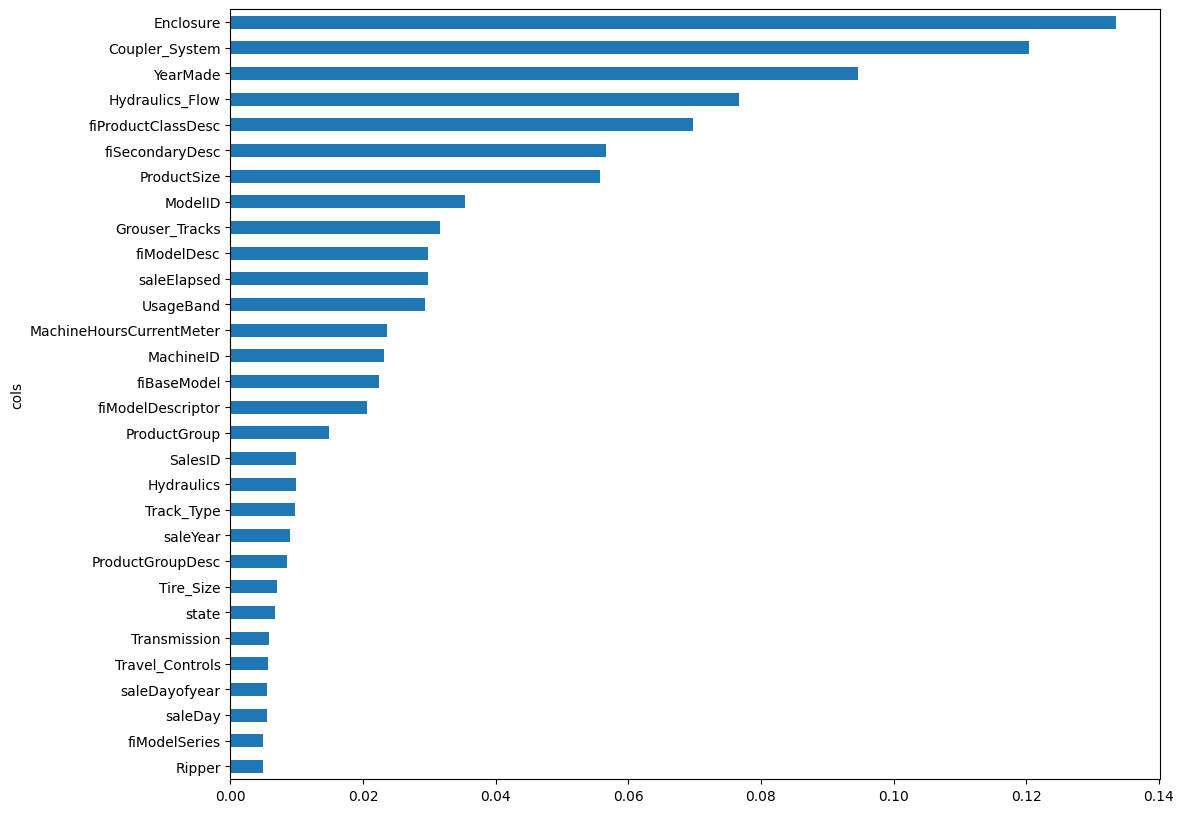

In [151]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

#### Ablation of least important features

Least important features can be discarded before re-training the random forest, where it yields a slight improvement of the model's validation $R^2$ score :

In [152]:
to_keep = feat_importance[feat_importance.imp > 0.005].cols
len(to_keep)

28

In [153]:
to_keep

19                   Enclosure
37              Coupler_System
5                     YearMade
39             Hydraulics_Flow
14          fiProductClassDesc
10             fiSecondaryDesc
13                 ProductSize
2                      ModelID
38              Grouser_Tracks
8                  fiModelDesc
63                 saleElapsed
7                    UsageBand
6     MachineHoursCurrentMeter
1                    MachineID
9                  fiBaseModel
12           fiModelDescriptor
16                ProductGroup
0                      SalesID
30                  Hydraulics
40                  Track_Type
51                    saleYear
17            ProductGroupDesc
35                   Tire_Size
15                       state
24                Transmission
48             Travel_Controls
56               saleDayofyear
54                     saleDay
Name: cols, dtype: object

In [154]:
# perform ablation of columns with low importance
df_keep = df[to_keep].copy()

n_total = len(df_keep)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


In [155]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small_keep, y_small)
print_score(model, X_small_keep, y_small, X_valid_keep, y_valid)

CPU times: user 3.25 s, sys: 45.6 ms, total: 3.29 s
Wall time: 578 ms
RMSE on train set: 0.1512
RMSE on valid set: 0.3269
R^2 on train set: 0.9538
R^2 on valid set: 0.8091
R^2 on oob set: 0.8879


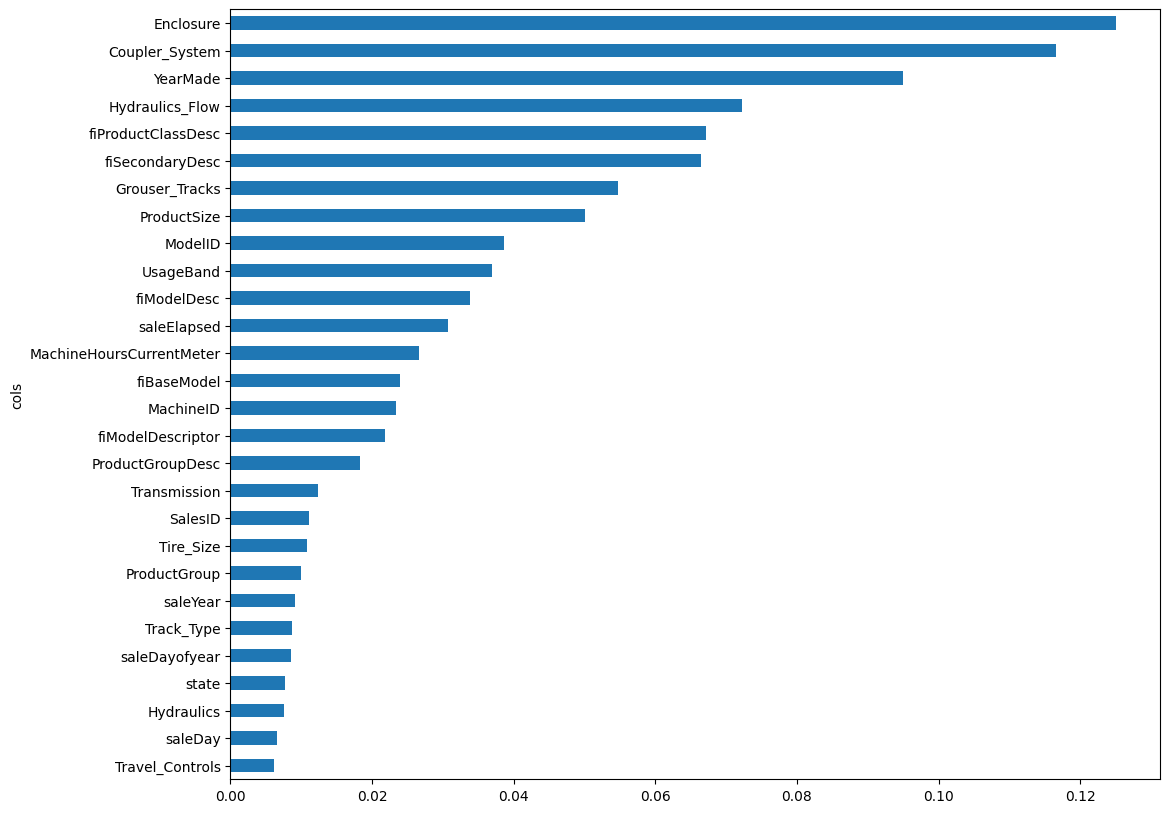

In [156]:
feat_importance = rf_feat_importance(model, X_small_keep)

barh = feat_importance.plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

<a id='permutation_feature_importance'></a>

### $\bullet$ Permutation importance

[Back to top](#plan)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator, and is not restricted to Random Forests. This is especially useful for non-linear or opaque estimators.


The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. Precisely, the `permutation_importance` function takes as input a fitted model and a validation set $\mathcal{D}$ with $d$ features, and compute the reference $R^2$ score sc of the model on this dataset. It then loops over a predefined number $k$ of repetitions, where during each loop $i$ a set of $d$ copies of the data are created, with in each copy $\mathcal{D}_{i, j}$ having feature $j$ being randomly shuffled (aka the term _permutation_). The $R^2$ score of the model is then computed on each of these corrupted copies of $\mathcal{D}$, yielding a set $\text{sc}_{i, j}$ of scores. The resulting importance score of each feature $j$ is then given by 

$$ \text{sc}_j = \text{sc} - \frac{1}{k}\sum_{i}\text{sc}_{i, j}$$


The importance of a feature is then higher as the model score decreases after corrupting this feature.
 


As for Random Forests impurity-based feature importance, feature importance based on permutation is of value only for good models (not overfitted and with descent cross-validated score), and does not reflect to the intrinsic predictive value of a feature by itself, but how important this feature is for a particular model.


See more on [scikit-learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

In [157]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 3.98 s, sys: 43 ms, total: 4.02 s
Wall time: 832 ms
RMSE on train set: 0.1486
RMSE on valid set: 0.3269
R^2 on train set: 0.9554
R^2 on valid set: 0.8092
R^2 on oob set: 0.8885


In [158]:
result = permutation_importance(
    model, 
    X_valid, 
    y_valid, 
    n_repeats = 10,
    random_state = 42, n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

In [159]:
result

{'importances_mean': array([ 6.66133815e-17,  9.12839972e-03,  2.22094040e-02,  7.77156117e-17,
         4.44089210e-17,  2.11840376e-01,  4.21365238e-03, -1.08827971e-03,
         2.11074745e-02,  1.61289225e-02,  8.35524588e-02,  3.15359577e-03,
         2.11281484e-02,  1.28711311e-01,  7.90850881e-02, -1.66018489e-05,
         1.10244736e-02,  4.02160611e-03,  2.30954342e-03,  1.23439053e-01,
        -1.61776252e-04,  8.31689618e-04, -1.57076510e-04,  1.71589423e-04,
         5.05241994e-03,  4.58096462e-04,  2.10677605e-04,  8.96112571e-04,
         1.71250017e-04,  3.64120814e-04,  4.62067697e-03,  1.16357303e-04,
         4.12549673e-03,  5.85110033e-04,  1.32142571e-04,  7.65044644e-03,
        -4.49269267e-04,  1.78136853e-01,  1.69006212e-02,  6.57405660e-02,
         1.21277477e-02,  2.89307906e-03,  3.75920105e-03,  3.02133986e-04,
         6.57926511e-04,  2.15312601e-04,  1.68971892e-04,  4.75691061e-04,
         8.21904144e-04,  1.49153491e-04,  1.96424603e-04,  1.641317

/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/2148425707.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


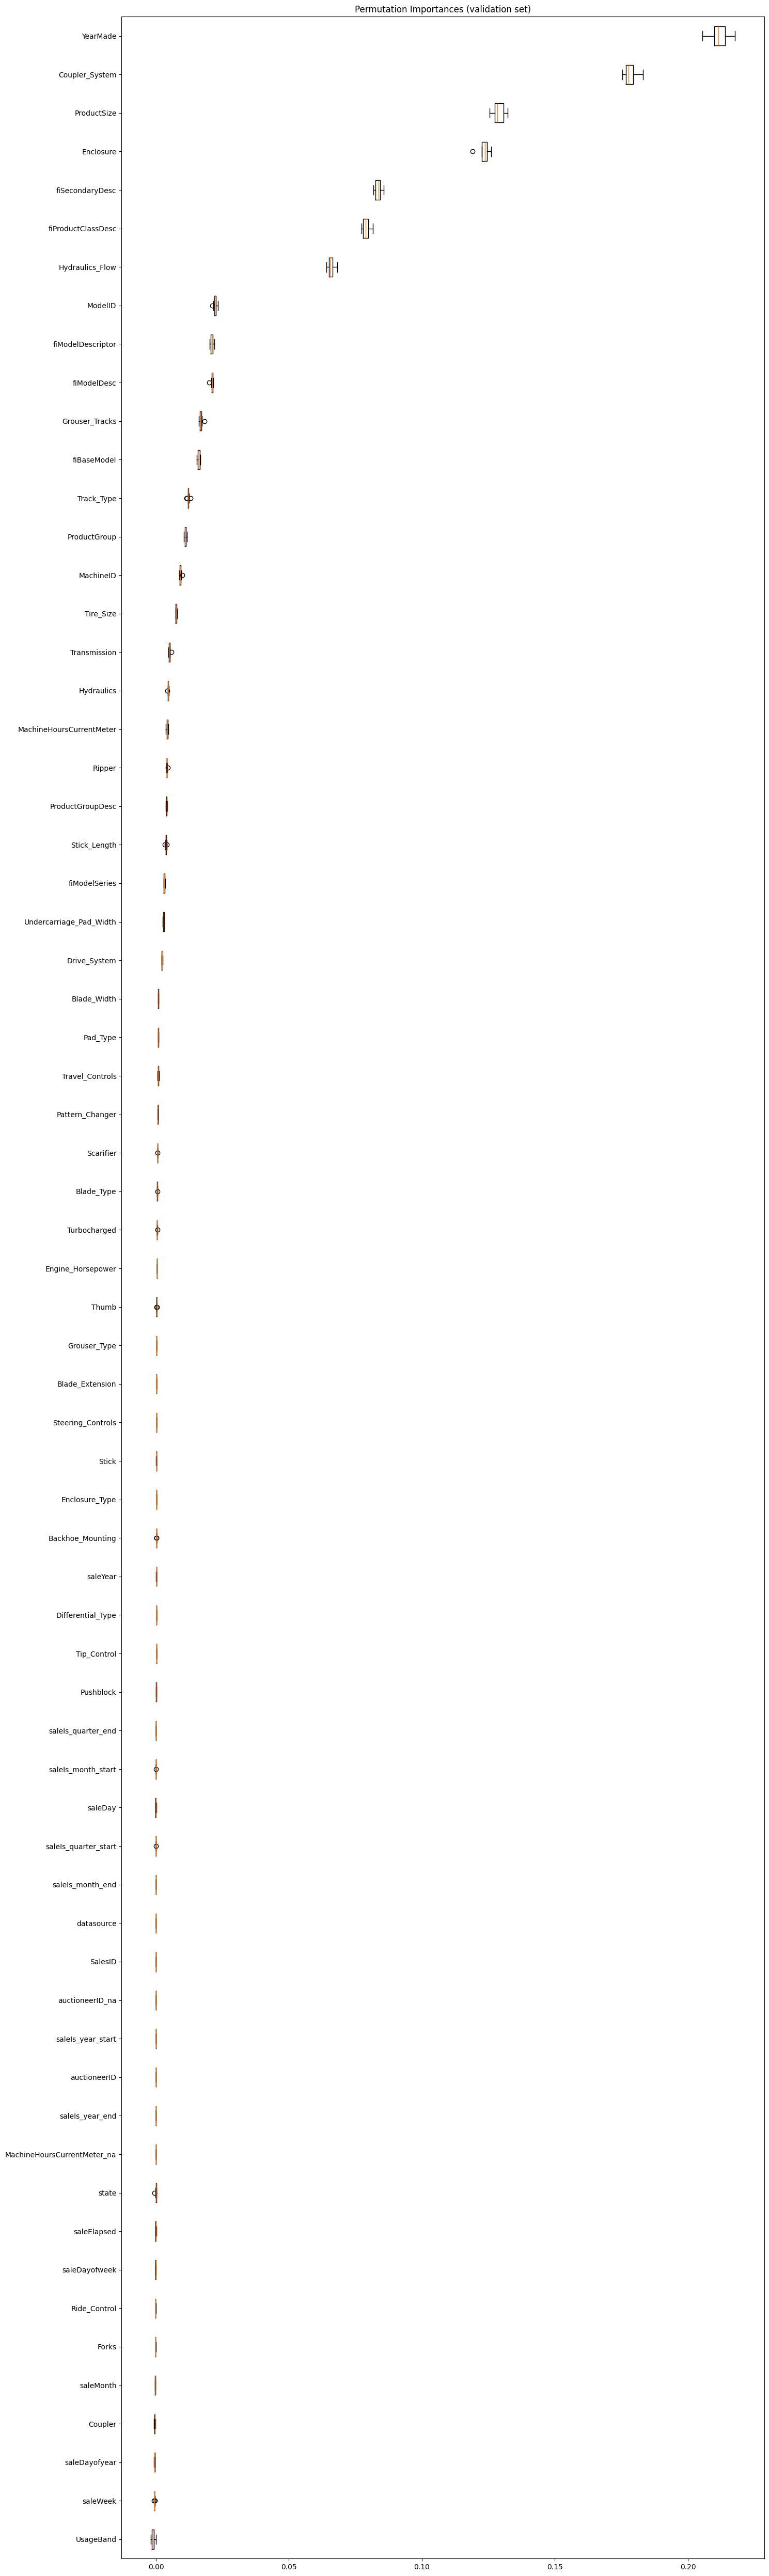

In [160]:
fig, ax = plt.subplots(figsize = (15, 50))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

#### Ablation of least important features

Least important features can be discarded before re-training the random forest, where it yields a **notable improvement** of the model's validation $R^2$ score :

In [161]:
bool_filter = result.importances_mean > 0.005
bool_filter

array([False,  True,  True, False, False,  True, False, False,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [162]:
to_keep = df.columns[bool_filter]

df_keep = df[to_keep].copy()

n_total = len(df_keep)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


In [163]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small_keep, y_small)
print_score(model, X_small_keep, y_small, X_valid_keep, y_valid)

CPU times: user 1.43 s, sys: 31.7 ms, total: 1.46 s
Wall time: 366 ms
RMSE on train set: 0.1967
RMSE on valid set: 0.3003
R^2 on train set: 0.9218
R^2 on valid set: 0.8389
R^2 on oob set: 0.8543


/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/3278640386.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


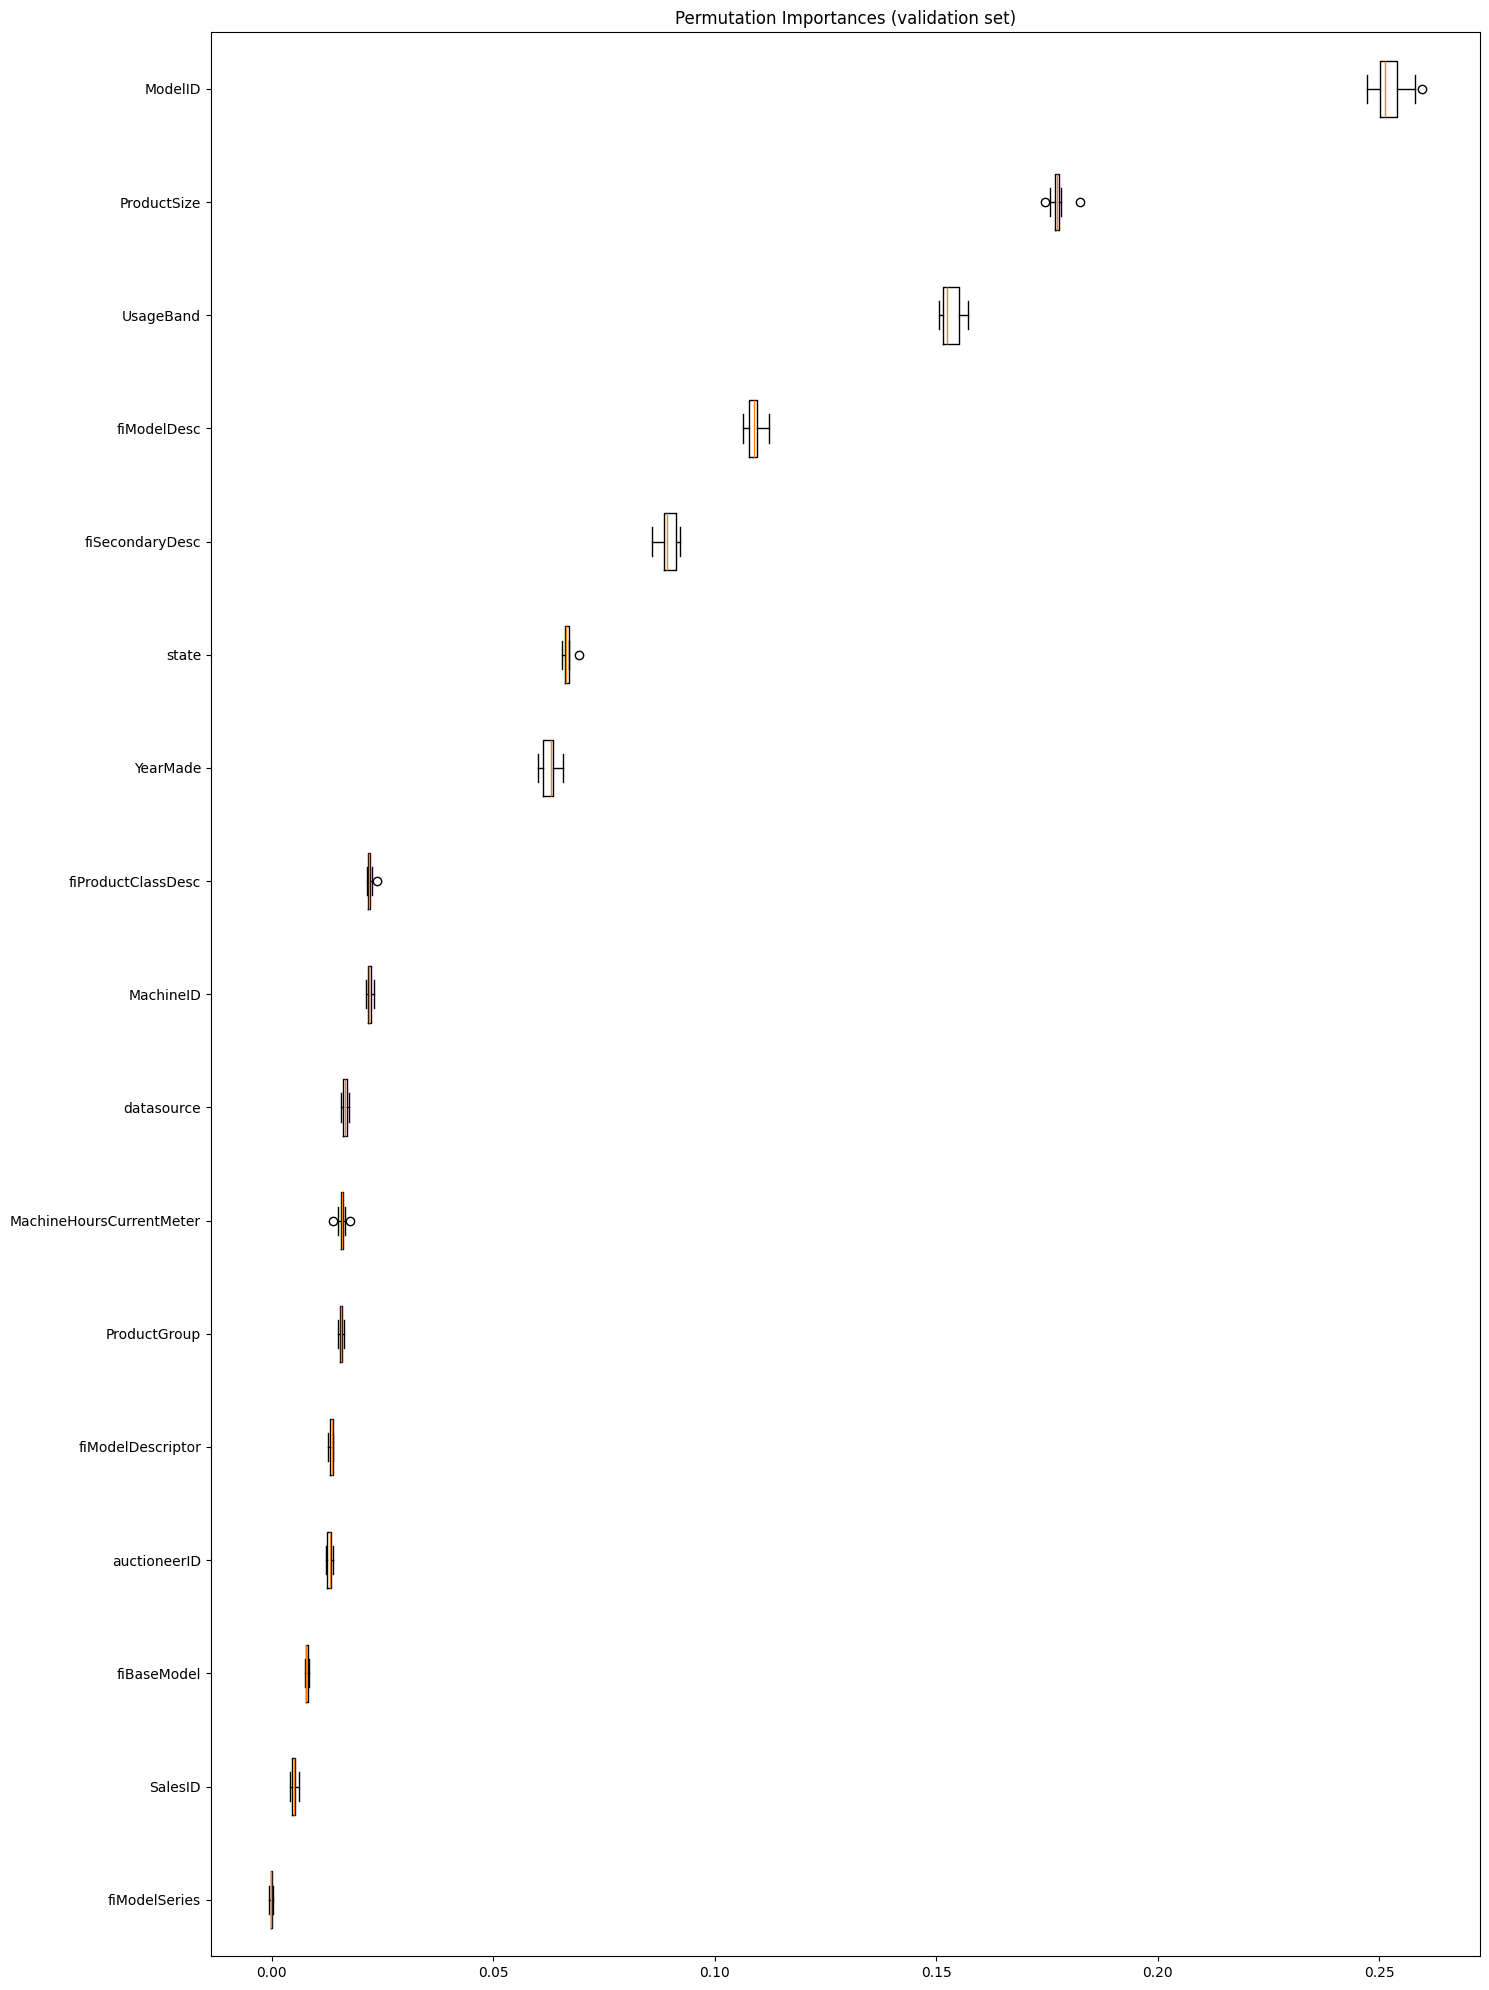

In [164]:
result = permutation_importance(
    model, 
    X_valid_keep, 
    y_valid, 
    n_repeats = 10,
    random_state = 42, n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

# plot boxplot
fig, ax = plt.subplots(figsize = (15, 20))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

#### Ablation after training on full data

Such ablation may hurt performance when the training (and validation) data is abundent :

In [165]:
model = RandomForestRegressor(
    n_estimators = 50,
    max_depth = 15,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 1min 27s, sys: 1.17 s, total: 1min 28s
Wall time: 14.8 s
RMSE on train set: 0.2071
RMSE on valid set: 0.2447
R^2 on train set: 0.9104
R^2 on valid set: 0.8931
R^2 on oob set: 0.8920


In [166]:
result = permutation_importance(
    model, 
    X_valid, 
    y_valid, 
    n_repeats = 5,
    random_state = 42, 
    n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/2148425707.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


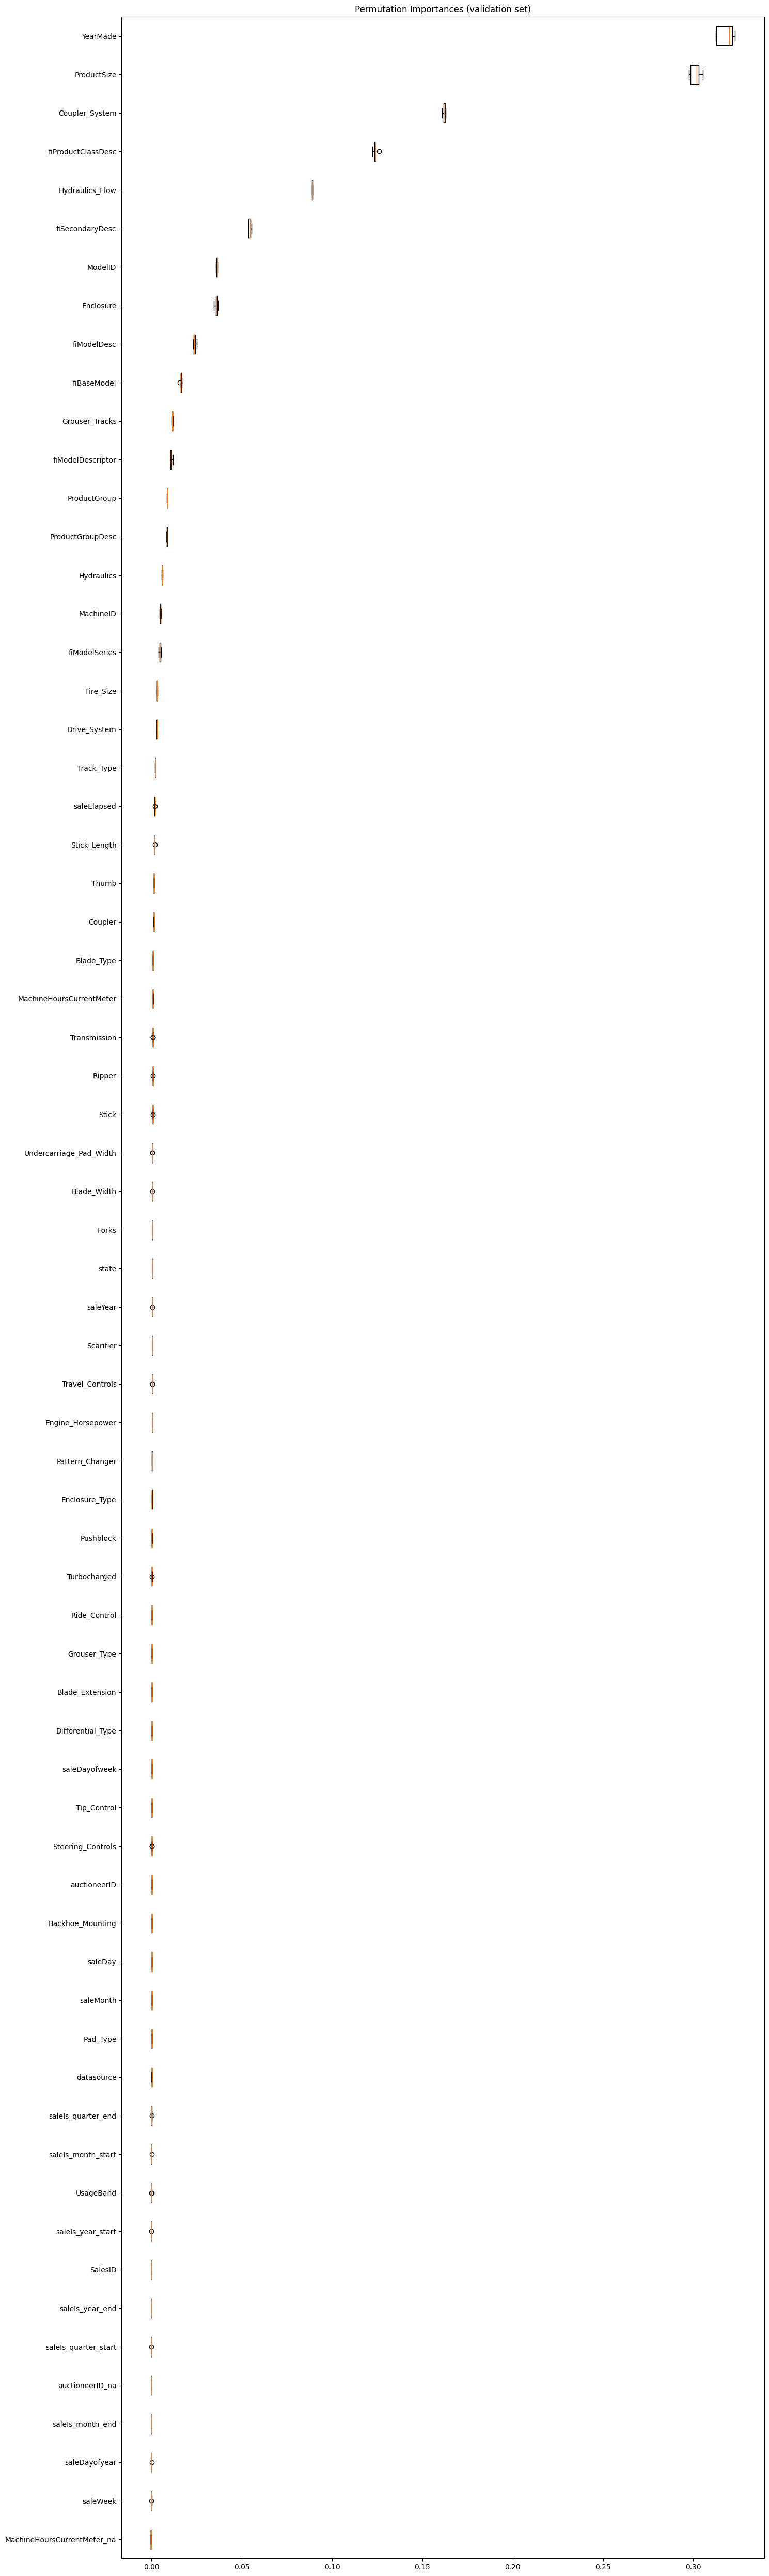

In [167]:
fig, ax = plt.subplots(figsize = (15, 50))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [168]:
bool_filter = result.importances_mean > 0.005
to_keep = df.columns[bool_filter]

df_keep = df[to_keep].copy()

n_total = len(df_keep)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


In [169]:
model = RandomForestRegressor(
    n_estimators = 50,
    max_depth = 15,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train_keep, y_train)
print_score(model, X_train_keep, y_train, X_valid_keep, y_valid)

CPU times: user 16.1 s, sys: 336 ms, total: 16.4 s
Wall time: 3.44 s
RMSE on train set: 0.2956
RMSE on valid set: 0.2839
R^2 on train set: 0.8174
R^2 on valid set: 0.8560
R^2 on oob set: 0.8062


In [170]:
# default is cv = 5
scores = cross_val_score(model, X_small_keep, y_small, cv = 5, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.83644536 0.84401421 0.82079998 0.8545795  0.801325  ]
r2 is 0.831 with a standard deviation of 0.019


<a id='redundant_features'></a>

### $\bullet$ Feature correlations

[Back to top](#plan)

If one computes permutation importance of features when some collinearity occurs, corrupting one feature will have little effect on the models performance because it can get the same information from a correlated feature. Because of that, the permutation importance will show that none of the features are important, which is in contradiction with a high validation that shows that some feature must be important. One approach to handling multicollinearity is by performing hierarchical clustering on the features’ Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.

In [171]:
# something is weird with this column
cols = df.columns.tolist()
cols.index('saleIs_year_start')

62

In [172]:
# something is weird with this column
cols = df.columns.tolist()
cols.remove('saleIs_year_start')
cols

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_q

We compute the Spearman rank-order correlation matrix of the explainatory variables using the `scipy` package. Each coefficient is a measure of the monotonicity of the relationship between two columns : it varies between -1 and +1, with 0 implying no correlation and correlations of -1 or +1 implying an exact monotonic relationship. Positive correlations imply that as x increases, so does y, whereas negative correlations imply that as x increases, y decreases.

In [173]:
len(df.columns)

66

In [174]:
corr = np.round(scipy.stats.spearmanr(df[cols]).correlation, 4)
corr.size

4225

/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/1015229442.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + col_small)
/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/1015229442.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + col_small)


[Text(0, -1.0, ''),
 Text(0, 0.0, 'Transmission'),
 Text(0, 1.0, 'Turbocharged'),
 Text(0, 2.0, 'Blade_Extension'),
 Text(0, 3.0, 'Blade_Width'),
 Text(0, 4.0, 'Enclosure_Type'),
 Text(0, 5.0, 'Engine_Horsepower'),
 Text(0, 6.0, 'Hydraulics'),
 Text(0, 7.0, 'Pushblock'),
 Text(0, 8.0, '')]

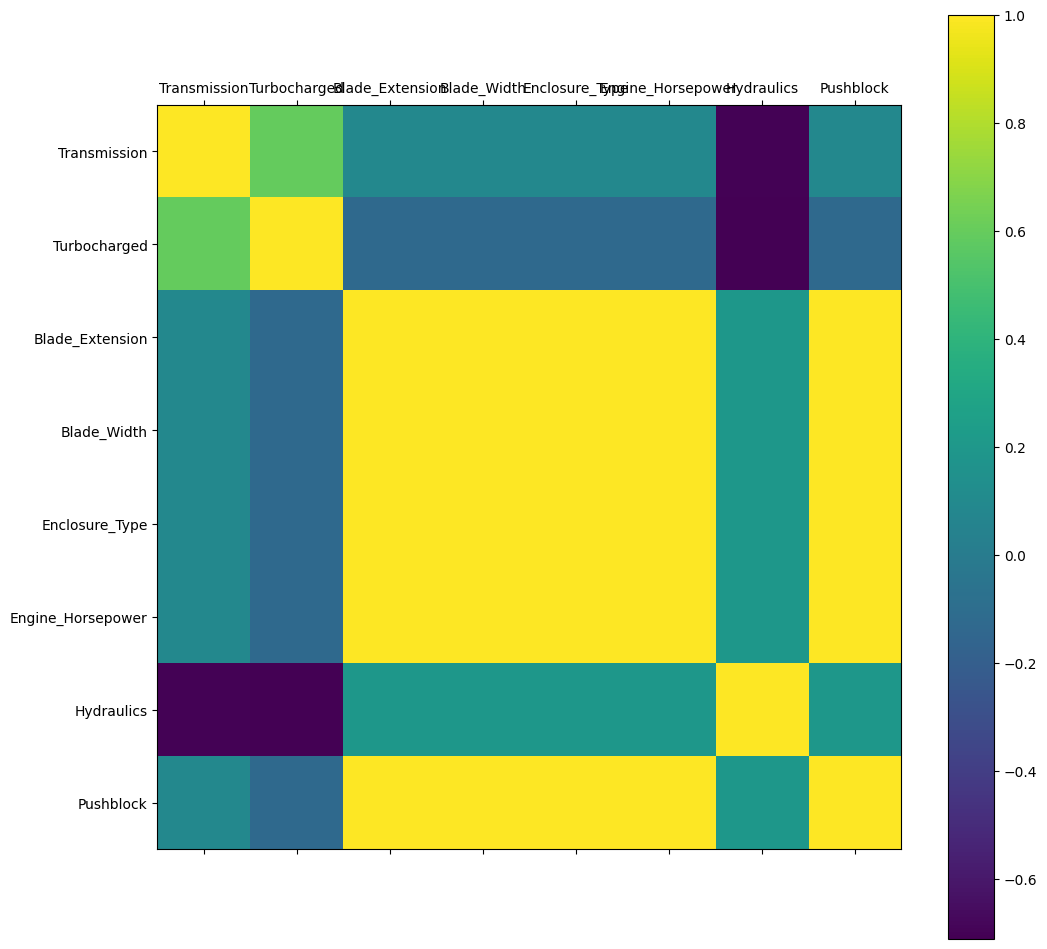

In [175]:
col_small = [
    'Transmission',
    'Turbocharged',
    'Blade_Extension',
    'Blade_Width',
    'Enclosure_Type',
    'Engine_Horsepower',
    'Hydraulics',
    'Pushblock',
]
corr_small = np.round(scipy.stats.spearmanr(df[col_small]).correlation, 4)
corr_small.size

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_small)

fig.colorbar(cax)

ax.set_xticklabels([''] + col_small)
ax.set_yticklabels([''] + col_small)


In [176]:
# corr with size = (65, 65) -> corr_condensed with size (65 * 64)/2
corr_condensed = hierarchy.distance.squareform(1 - corr)
corr_condensed.size

2080

In [177]:
(65 * 64)/2

2080.0

In [178]:
corr_linkage = hierarchy.linkage(corr_condensed, method = 'average')

In [179]:
corr_linkage

array([[1.60000000e+01, 1.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.60000000e+01, 2.90000000e+01, 1.00000000e-04, 2.00000000e+00],
       [8.00000000e+00, 9.00000000e+00, 3.00000000e-04, 2.00000000e+00],
       [2.80000000e+01, 6.60000000e+01, 3.50000000e-04, 3.00000000e+00],
       [3.80000000e+01, 3.90000000e+01, 5.00000000e-04, 2.00000000e+00],
       [3.10000000e+01, 6.80000000e+01, 5.00000000e-04, 4.00000000e+00],
       [3.40000000e+01, 7.00000000e+01, 7.00000000e-04, 5.00000000e+00],
       [2.70000000e+01, 7.10000000e+01, 8.60000000e-04, 6.00000000e+00],
       [3.30000000e+01, 7.20000000e+01, 1.11666667e-03, 7.00000000e+00],
       [4.90000000e+01, 5.00000000e+01, 1.20000000e-03, 2.00000000e+00],
       [3.70000000e+01, 6.90000000e+01, 1.85000000e-03, 3.00000000e+00],
       [5.10000000e+01, 6.20000000e+01, 2.40000000e-03, 2.00000000e+00],
       [5.30000000e+01, 5.60000000e+01, 2.40000000e-03, 2.00000000e+00],
       [2.10000000e+01, 2.50000000e+01, 2.50000000e

In [180]:
help(hierarchy.linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents t

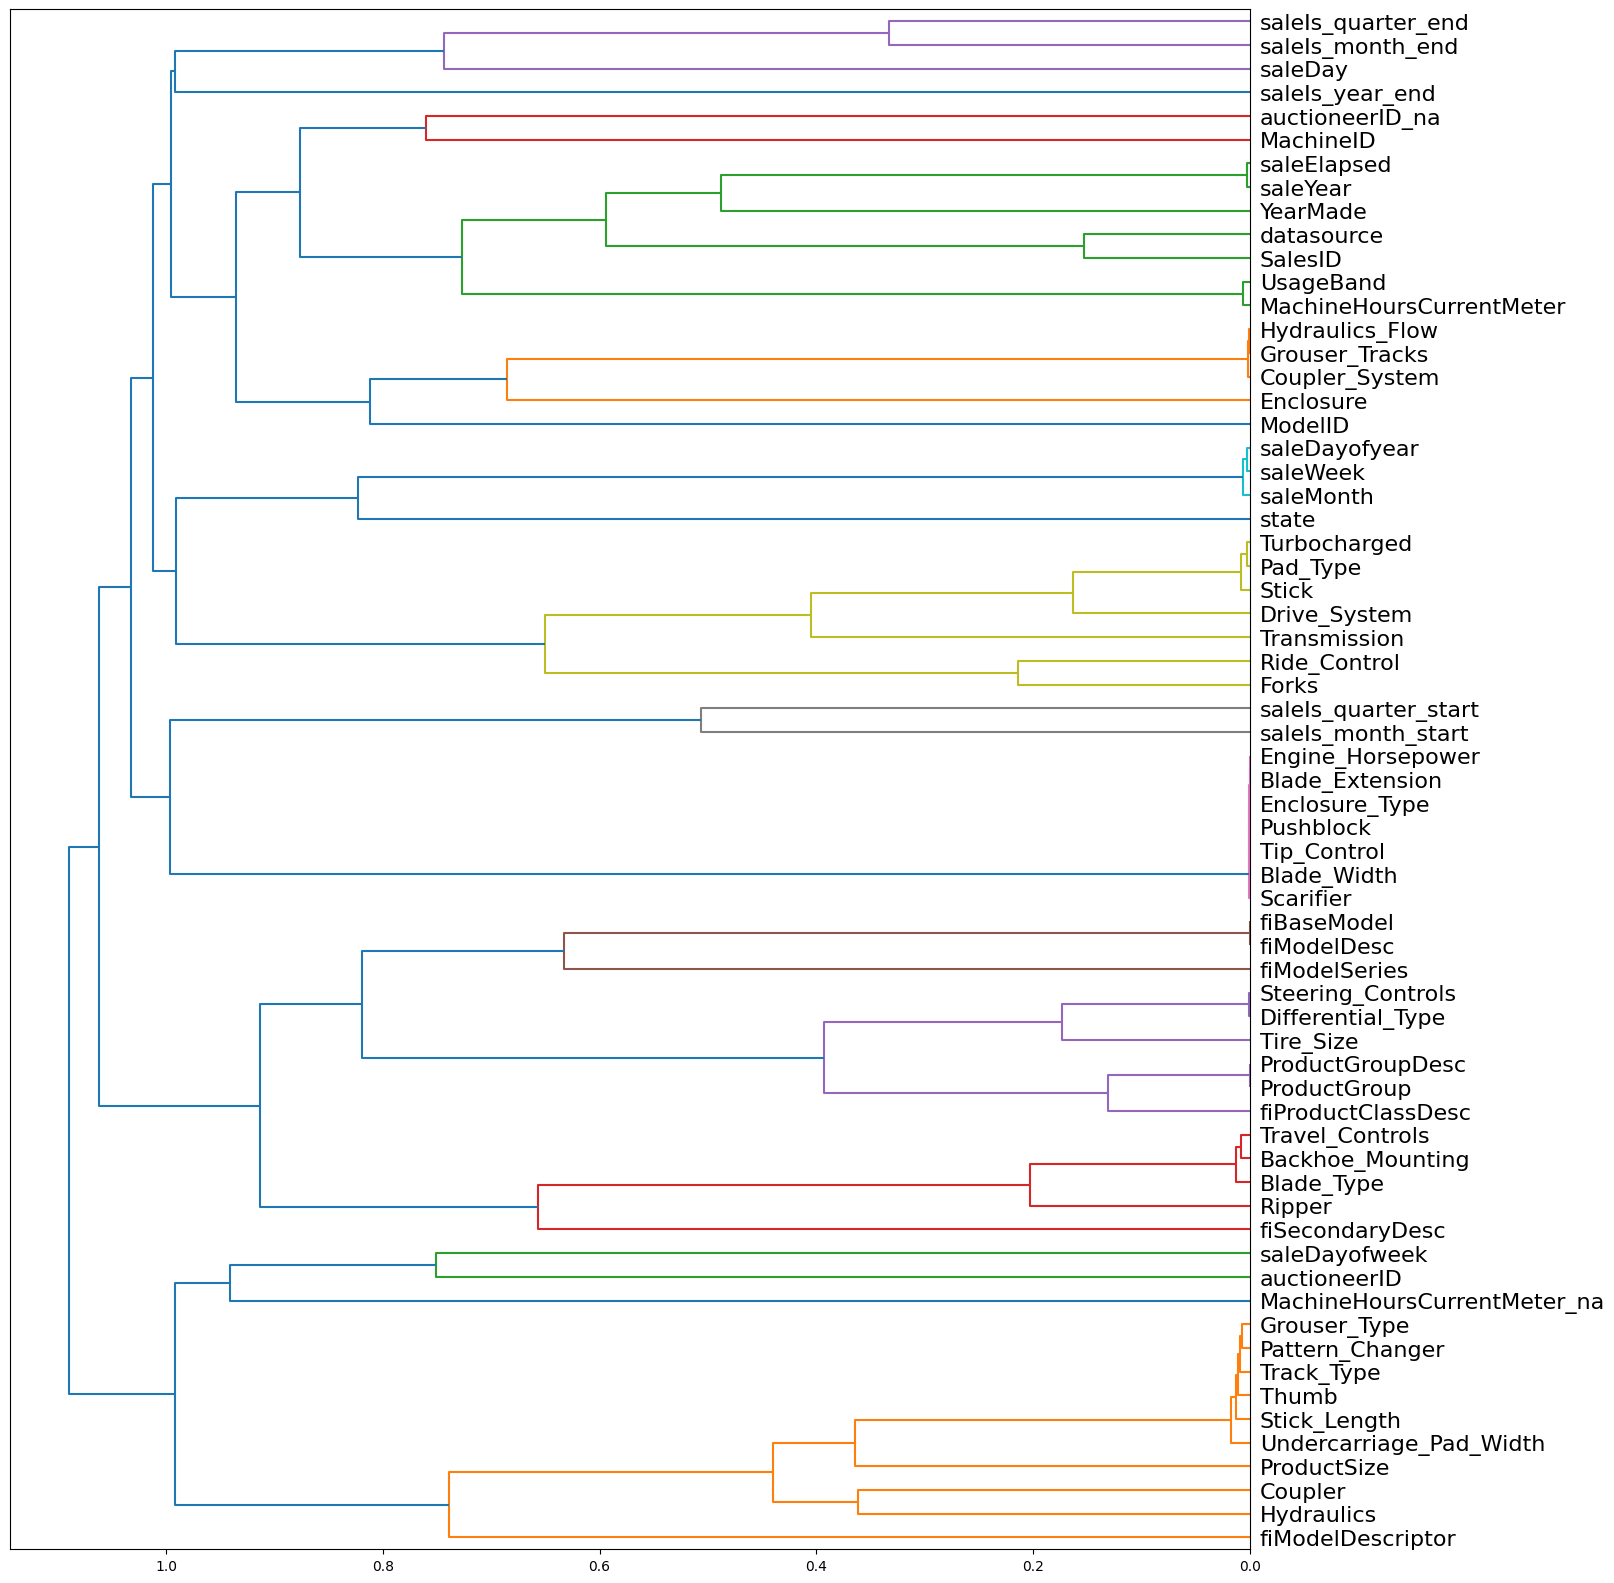

In [181]:


# compute plot
fig = plt.figure(figsize = (16,20))
dendrogram = hierarchy.dendrogram(
    corr_linkage, 
    labels = cols, 
    orientation = 'left', 
    leaf_font_size = 16,
)
plt.show()

In [182]:
from collections import defaultdict

In [183]:
# compute hierarchical clustering
threshold = 0.1
cluster_ids = hierarchy.fcluster(corr_linkage, threshold, criterion = 'distance')

In [184]:
cluster_ids

array([32, 36, 30, 33,  6, 35, 31, 31, 16, 16, 11, 17,  5,  4, 13, 27, 12,
       12, 24, 29, 21, 23, 22, 23, 25, 23, 18, 18, 18, 18,  1, 18, 10, 18,
       18, 15,  2, 28, 28, 28,  3,  3,  3,  3,  3,  3,  9,  9,  9, 14, 14,
       34, 26, 26, 40,  7, 26, 38, 19, 39, 20, 41, 34, 37,  8],
      dtype=int32)

In [185]:
# reshape clustering as {cluster_index : feature_index}
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

In [186]:
cluster_id_to_feature_ids

defaultdict(list,
            {np.int32(32): [0],
             np.int32(36): [1],
             np.int32(30): [2],
             np.int32(33): [3],
             np.int32(6): [4],
             np.int32(35): [5],
             np.int32(31): [6, 7],
             np.int32(16): [8, 9],
             np.int32(11): [10],
             np.int32(17): [11],
             np.int32(5): [12],
             np.int32(4): [13],
             np.int32(13): [14],
             np.int32(27): [15],
             np.int32(12): [16, 17],
             np.int32(24): [18],
             np.int32(29): [19],
             np.int32(21): [20],
             np.int32(23): [21, 23, 25],
             np.int32(22): [22],
             np.int32(25): [24],
             np.int32(18): [26, 27, 28, 29, 31, 33, 34],
             np.int32(1): [30],
             np.int32(10): [32],
             np.int32(15): [35],
             np.int32(2): [36],
             np.int32(28): [37, 38, 39],
             np.int32(3): [40, 41, 42, 43, 44, 45],
  

In [187]:
# keep only first feature for each cluster
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# shift feature index after 62
selected_features = [(i if i < 62 else i+1) for i in selected_features]

In [188]:
selected_features

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 24,
 26,
 30,
 32,
 35,
 36,
 37,
 40,
 46,
 49,
 51,
 52,
 54,
 55,
 57,
 58,
 59,
 60,
 61,
 64,
 65]

In [189]:
# retained set of features
selected_features = [df.columns[i] for i in selected_features]
selected_features

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'fiModelDesc',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Transmission',
 'Blade_Extension',
 'Hydraulics',
 'Ripper',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Track_Type',
 'Backhoe_Mounting',
 'Differential_Type',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayofweek',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'auctioneerID_na',
 'MachineHoursCurrentMeter_na']

In [190]:
len(selected_features)

41

#### Perform training on ablated set of features

In [191]:
df_keep = df[selected_features].copy()

n_total = len(df_keep)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


In [192]:
model = RandomForestRegressor(
    n_estimators = 50,
    max_depth = 15,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train_keep, y_train)
print_score(model, X_train_keep, y_train, X_valid_keep, y_valid)

CPU times: user 1min 2s, sys: 993 ms, total: 1min 3s
Wall time: 11.2 s
RMSE on train set: 0.2110
RMSE on valid set: 0.2458
R^2 on train set: 0.9070
R^2 on valid set: 0.8921
R^2 on oob set: 0.8879


The model performance does not improve. Let us now see if some features shows up as important and wasn't before due to the correlation issues :

#### Permutation of feature importance after feature selection

In [193]:
result = permutation_importance(
    model, 
    X_valid_keep, 
    y_valid, 
    n_repeats = 5,
    random_state = 42, 
    n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_11805/2148425707.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


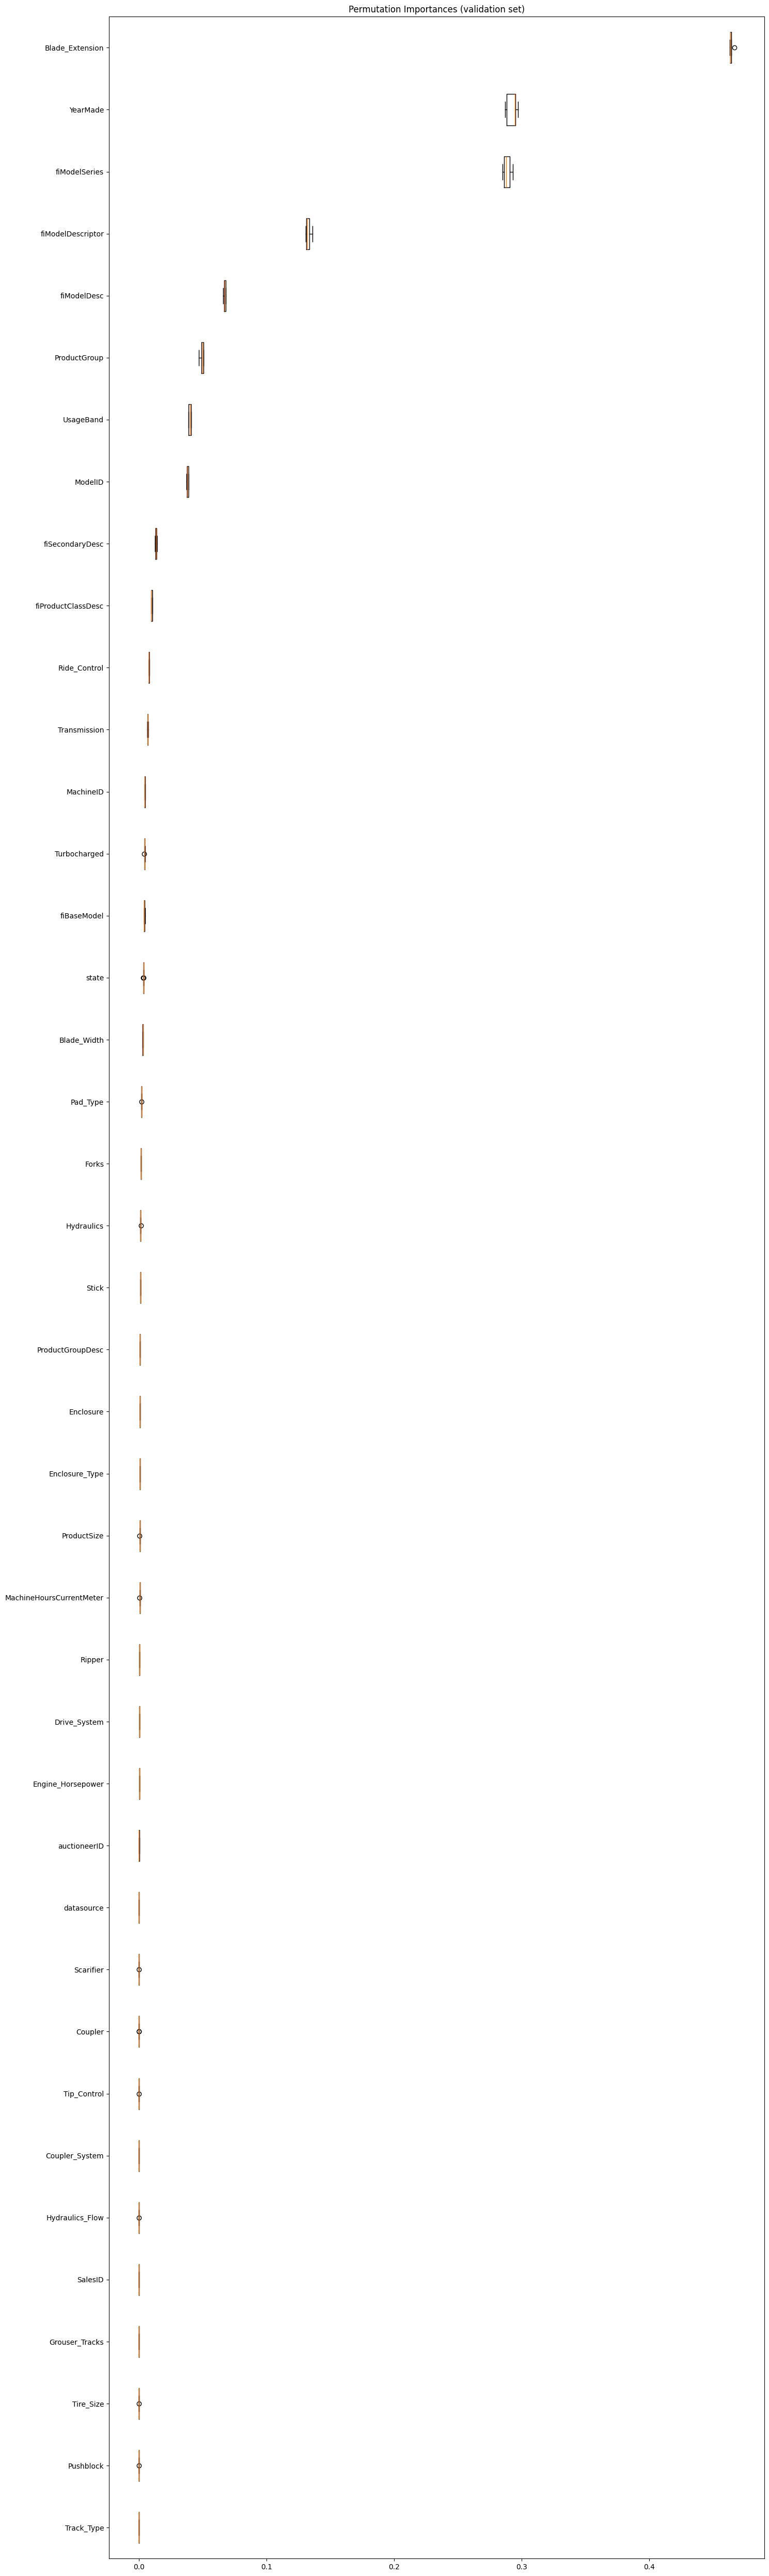

In [194]:
fig, ax = plt.subplots(figsize = (15, 50))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

**Conclusion** : We now see that `Blade_Extension`overtakes `YearMade`as the most discriminant variable. This makes a lot of sense since according to the previous dendrogram this features is extremely correlated with the feature `Engine_Horsepower`, which indeed must heavily impact the sale price.

<a id='bottom'></a>

[Back to top](#plan)